In [362]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
import pandas as pd
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import run_SLAT_multi
from scSLAT.viz import build_3D
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata
from scSLAT.viz import match_3D_multi, hist, match_3D_celltype, Sankey
from scSLAT.metrics import region_statistics


In [363]:
adata_1=sc.read_h5ad('D:\ppppaper\data\BrCa\BrCa_section2_add_tumor_region.h5ad')
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'tumor_region_simple'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'tumor_region_colors', 'tumor_region_simple_colors'
    obsm: 'spatial'

In [364]:
adata_2=sc.read_h5ad('D:\ppppaper\data\BrCa\BrCa_section1_add_tumor_region.h5ad')
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'spatial'
    obsm: 'spatial'

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

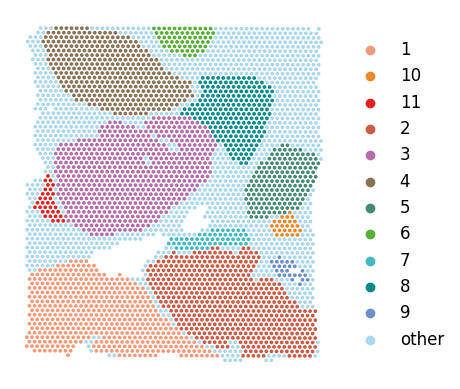

In [365]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                   "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC"]
sc.pl.spatial(adata_1, img_key=None, color=['Cell_type'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

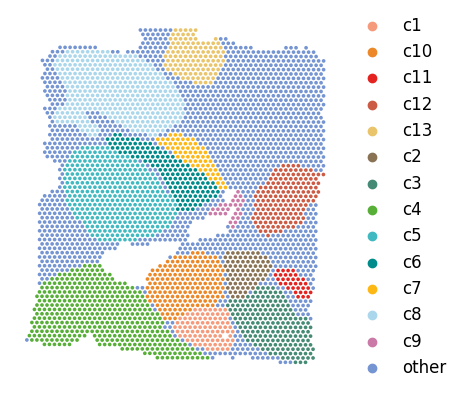

In [366]:
# import matplotlib.pyplot as plt
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#E9C46A", "#8A7355", "#458A74",
                   "#57AF37", "#41B9C1", "#008B8B", "#FDB815", "#ABD7EC", "#CB79A6", "#7494D2"]
sc.pl.spatial(adata_2, img_key=None, color=['Cell_type'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)
# plt.savefig('spatial_plot.png', dpi=300, bbox_inches='tight') 
# plt.close()  

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

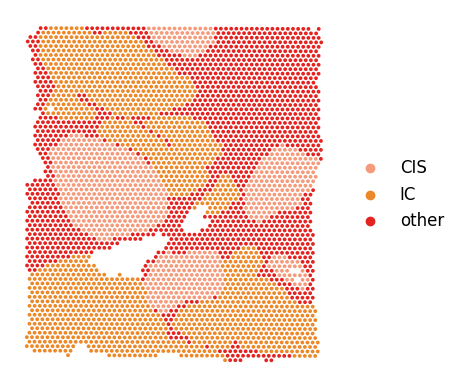

In [367]:
sc.pl.spatial(adata_1, img_key=None, color=['tumor_region_simple'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

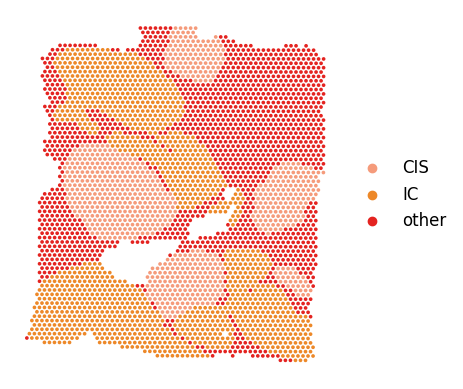

In [368]:
sc.pl.spatial(adata_2, img_key=None, color=['tumor_region'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [369]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [370]:
Cal_Spatial_Net(adata_1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 41691 edges, 3987 cells.
10.45673438675696 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 39636 edges, 3798 cells.
10.436018957345972 neighbors per cell on average.


In [371]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [372]:
embd0, embd1, time = run_SLAT_mlp_AGF(features, edges, location)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.01 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 1 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- ep

In [373]:
adata_1.obsm['scSLAT_bks'] = embd0.detach().cpu().numpy()
adata_2.obsm['scSLAT_bks'] = embd1.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com)


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


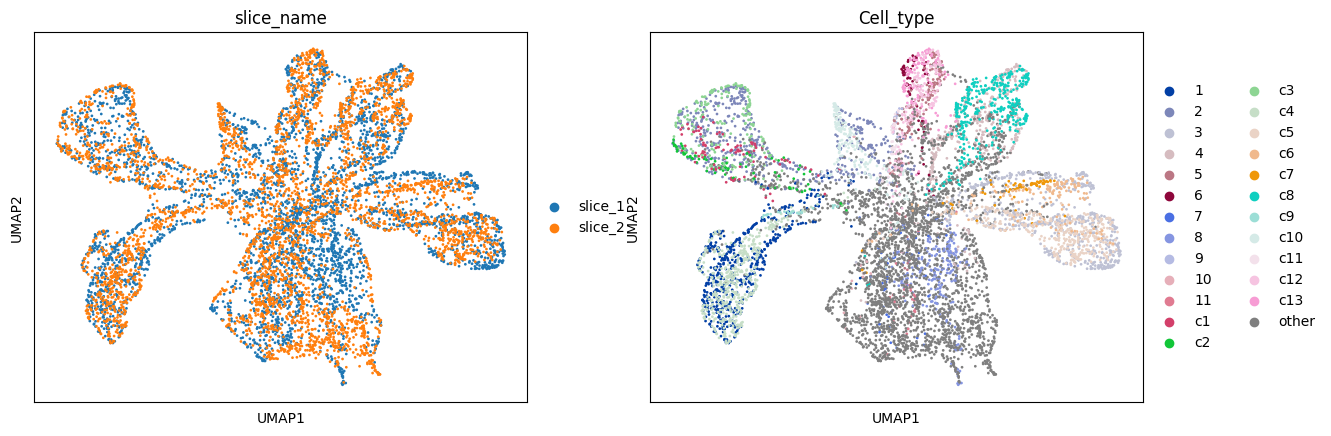

In [374]:
sc.pl.umap(adata_com, color= ['slice_name', 'Cell_type'])

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


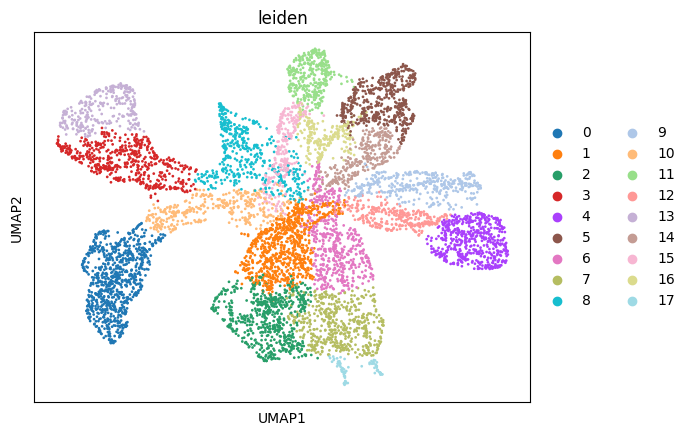

18

In [375]:
sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks', random_state= 666)
sc.tl.leiden(adata_com, resolution=0.6)
# sc.tl.louvain(adata_com, resolution=1.0, random_state=0)
# sc.pl.umap(adata_com, color=['leiden'])

# Plot UMAP with the clustering results
sc.pl.umap(adata_com, color=['leiden'])
len(adata_com.obs.leiden.cat.categories)

In [376]:
embd2, embd3, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 28.15


In [377]:
adata_1.obsm['scSLAT'] = embd2.detach().cpu().numpy()
adata_2.obsm['scSLAT'] = embd3.detach().cpu().numpy()
adata_com_2 = sc.concat([adata_1,adata_2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com_2, use_rep= 'scSLAT')
sc.tl.umap(adata_com_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


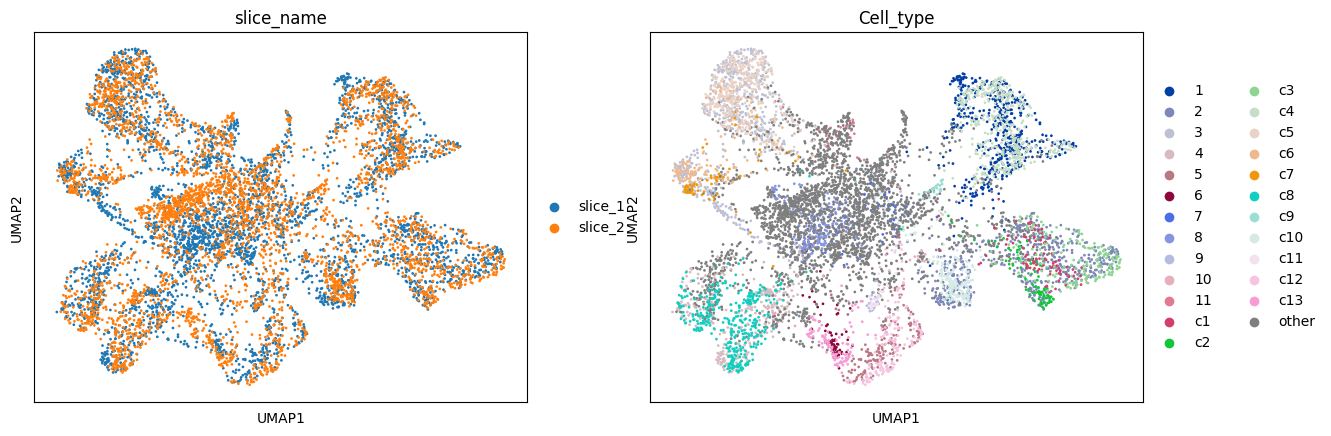

In [378]:
sc.pl.umap(adata_com_2, color= ['slice_name', 'Cell_type'])

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


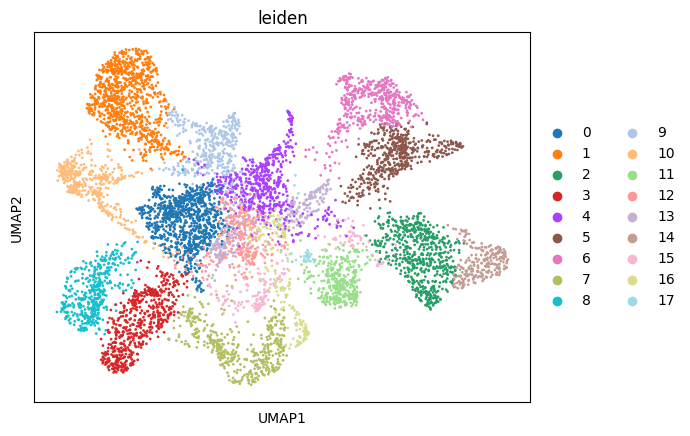

18

In [379]:
sc.pp.neighbors(adata_com_2, use_rep= 'scSLAT', random_state= 666)
sc.tl.leiden(adata_com_2, resolution=1)
# sc.tl.louvain(adata_com, resolution=1.0, random_state=0)
# sc.pl.umap(adata_com, color=['leiden'])

# Plot UMAP with the clustering results
sc.pl.umap(adata_com_2, color=['leiden'])
len(adata_com_2.obs.leiden.cat.categories)

In [380]:
# LISI
adata_1.obsm['X_umap'] = adata_1.obsm['scSLAT_bks']
adata_2.obsm['X_umap'] = adata_2.obsm['scSLAT_bks']
adata_com.obsm['X_umap'] = adata_com.obsm['scSLAT_bks']

lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='X_umap', obs_key_list=['Cell_type', 'slice_name'])
print("LISI Scores:\n", lisi_scores)


LISI Scores:
 {'cLISI': 1.8501612318269152, 'iLISI': 1.621046570441716}


In [381]:
true_labels_1 = adata_1.obs['Cell_type'].to_numpy()
true_labels_2 = adata_2.obs['Cell_type'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.48241259790485647, NMI: 0.6088833600515622


In [382]:
true_labels_1 = adata_1.obs['Cell_type'].to_numpy()
true_labels_2 = adata_2.obs['Cell_type'].to_numpy()

best_2, index_2, distance_2 = spatial_match([embd2, embd3], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_2 < true_labels_1.size
valid_best = best_2[valid_indices]
valid_indices = np.arange(len(best_2))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.4615887342562829, NMI: 0.6198799761940987


In [383]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['Cell_type']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['Cell_type']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [384]:
adata3_df = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['Cell_type']})
adata4_df = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['Cell_type']})

matching_2 = np.array([range(index_2.shape[0]), best_2])
best_match_2 = distance_2[:,0]

In [385]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [386]:
adata4_df['target_celltype'] = adata3_df.iloc[matching_2[1,:],:]['celltype'].to_list()
matching_table_2 = adata4_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

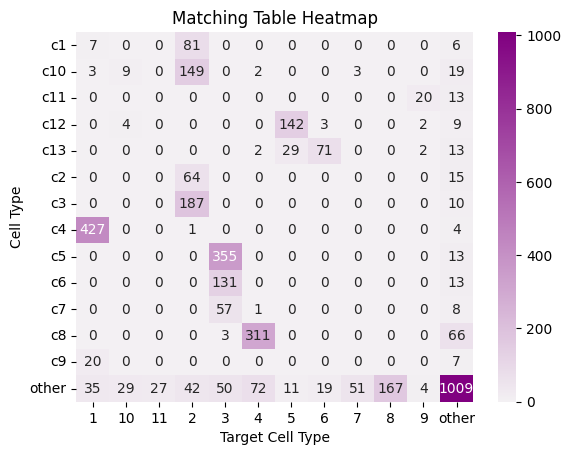

In [387]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_cmap = sns.color_palette("light:purple", as_cmap=True)

sns.heatmap(matching_table, annot = True, fmt = "d", cmap = custom_cmap)
plt.title('Matching Table Heatmap')
plt.xlabel('Target Cell Type')
plt.ylabel('Cell Type')
plt.show()

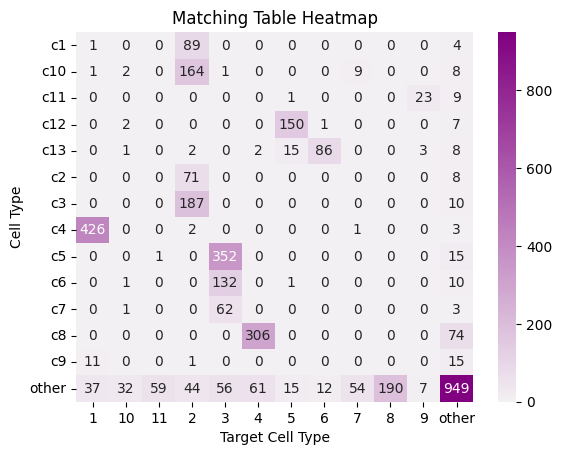

In [388]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_cmap = sns.color_palette("light:purple", as_cmap=True)

sns.heatmap(matching_table_2, annot = True, fmt = "d", cmap = custom_cmap)
plt.title('Matching Table Heatmap')
plt.xlabel('Target Cell Type')
plt.ylabel('Cell Type')
plt.show()

In [389]:
adata1_df_tumor = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'tumor_region': adata_1.obs['tumor_region_simple']})
adata2_df_tumor = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'tumor_region': adata_2.obs['tumor_region']})

matching_tumor = np.array([range(index.shape[0]), best])
best_match_tumor = distance[:,0]

In [390]:
adata2_df_tumor['target'] = adata1_df_tumor.iloc[matching_tumor[1,:],:]['tumor_region'].to_list()
matching_table_tumor = adata2_df_tumor.groupby(['tumor_region','target']).size().unstack(fill_value=0)

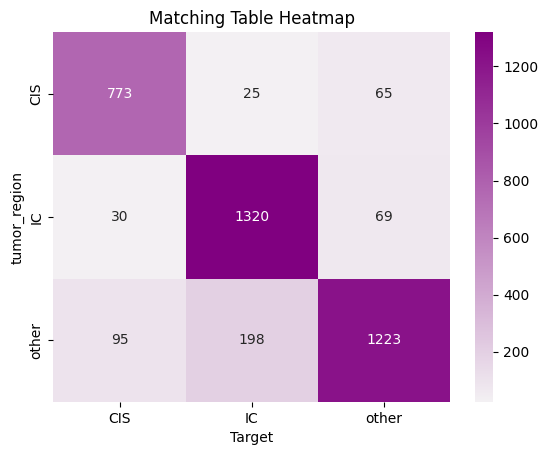

In [391]:
custom_cmap = sns.color_palette("light:purple", as_cmap=True)

sns.heatmap(matching_table_tumor, annot = True, fmt = "d", cmap = custom_cmap)
plt.title('Matching Table Heatmap')
plt.xlabel('Target')
plt.ylabel('tumor_region')
plt.show()

In [392]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_tumor.iterrows():
    if i in matching_table_tumor.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(3316, 3798, 0.8730911005792522)

dataset1: 3 cell types; dataset2: 3 cell types; 
                    Total :3 celltypes; Overlap: 3 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 3798


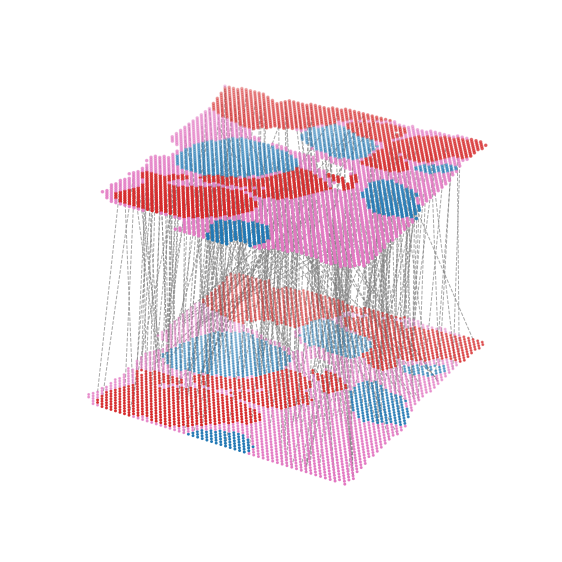

In [393]:
multi_align_tumor = match_3D_multi(adata1_df_tumor, adata2_df_tumor, matching, meta='tumor_region',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align_tumor.draw_3D(size=[7, 8], line_width=0.7, line_color='grey', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False)

In [394]:
adata3_df_tumor = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'tumor_region': adata_1.obs['tumor_region_simple']})
adata4_df_tumor = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'tumor_region': adata_2.obs['tumor_region']})

matching_2_tumor = np.array([range(index_2.shape[0]), best_2])
best_match_2_tumor = distance_2[:,0]

In [395]:
adata4_df_tumor['target'] = adata3_df_tumor.iloc[matching_2_tumor[1,:],:]['tumor_region'].to_list()
matching_table_2_tumor = adata4_df_tumor.groupby(['tumor_region','target']).size().unstack(fill_value=0)

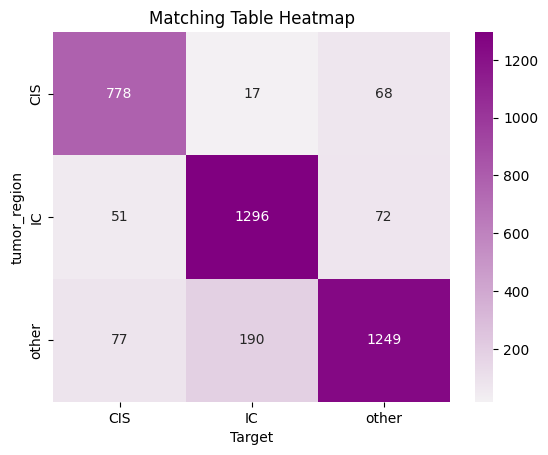

In [396]:
sns.heatmap(matching_table_2_tumor, annot = True, fmt = "d", cmap = custom_cmap)
plt.title('Matching Table Heatmap')
plt.xlabel('Target')
plt.ylabel('tumor_region')
plt.show()

In [397]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_2_tumor.iterrows():
    if i in matching_table_2_tumor.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(3323, 3798, 0.8749341758820431)

dataset1: 12 cell types; dataset2: 14 cell types; 
                    Total :25 celltypes; Overlap: 1 cell types 
                    Not overlap :[['11', '2', '9', '4', '6', '7', '8', '1', '10', '3', '5', 'c11', 'c9', 'c1', 'c10', 'c7', 'c12', 'c3', 'c13', 'c5', 'c8', 'c2', 'c4', 'c6']]
Subsampled 300 pairs from 3798


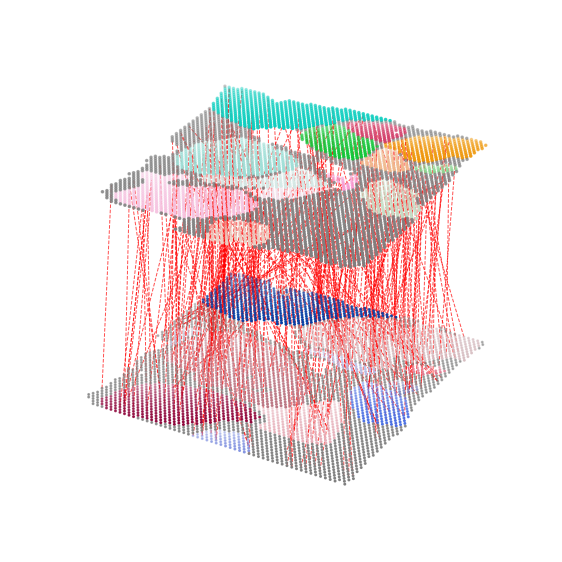

In [398]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align.draw_3D(size=[7, 8], line_width=0.7, line_color='red', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False)

dataset1: 12 cell types; dataset2: 14 cell types; 
                    Total :25 celltypes; Overlap: 1 cell types 
                    Not overlap :[['11', '2', '9', '4', '6', '7', '8', '1', '10', '3', '5', 'c11', 'c9', 'c1', 'c10', 'c7', 'c12', 'c3', 'c13', 'c5', 'c8', 'c2', 'c4', 'c6']]
Subsampled 300 pairs from 3798


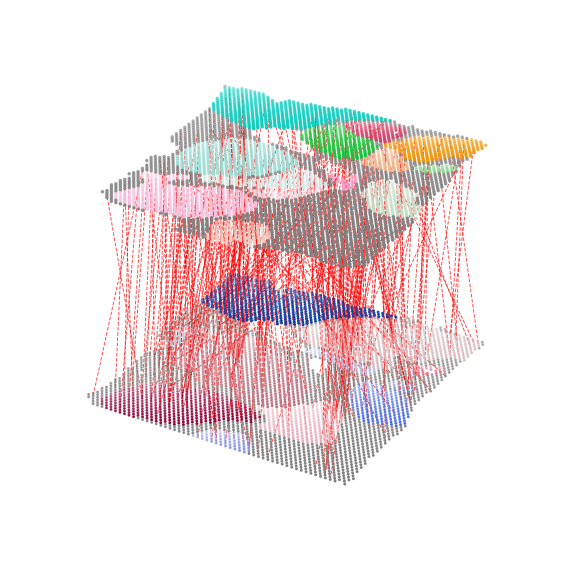

In [399]:
multi_align_2 = match_3D_multi(adata3_df, adata4_df, matching_2, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align_2.draw_3D(size=[7, 8], line_width=0.7, line_color='red', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False)

In [400]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values

max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels

adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

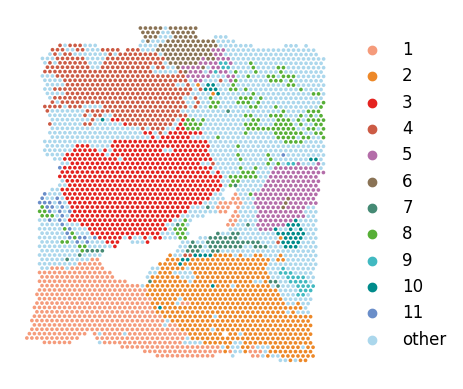

In [401]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                   "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC"]

sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

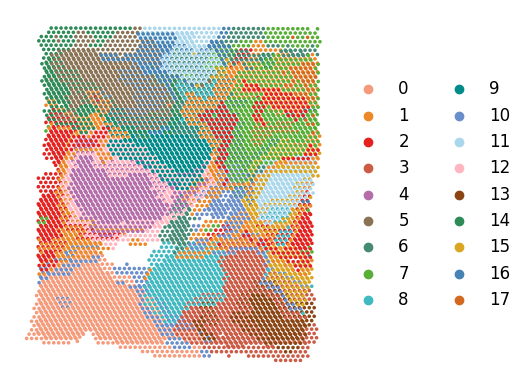

In [402]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                     "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC",
                     "#FFB6C1", "#8B4513", "#2E8B57", "#DAA520", "#4682B4", "#D2691E",
                     "#9ACD32", "#00CED1"]

sc.pl.spatial(adata_com, img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

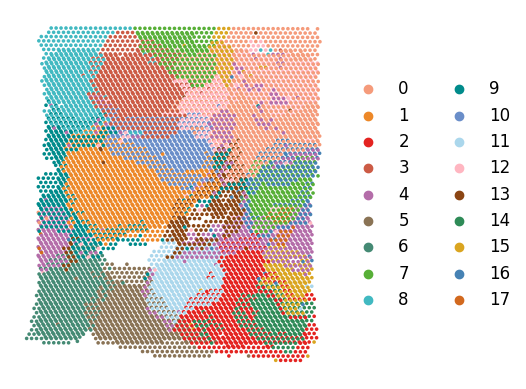

In [403]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                     "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC",
                     "#FFB6C1", "#8B4513", "#2E8B57", "#DAA520", "#4682B4", "#D2691E",
                     "#9ACD32", "#00CED1"]

sc.pl.spatial(adata_com_2, img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [404]:
adata_com.shape

(7785, 36601)

In [405]:
adata_com[0:3987,:]

View of AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'slice_name', 'leiden'
    uns: 'neighbors', 'umap', 'slice_name_colors', 'Cell_type_colors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'scSLAT_bks', 'X_umap'
    obsp: 'distances', 'connectivities'

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

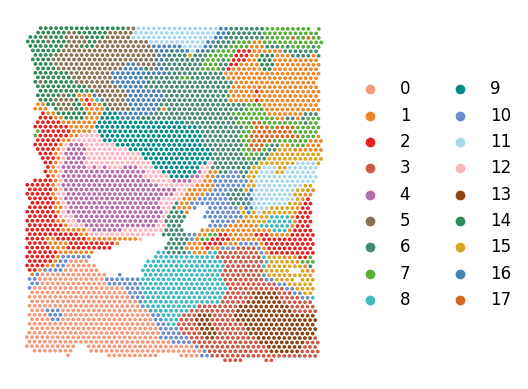

In [406]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                     "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC",
                     "#FFB6C1", "#8B4513", "#2E8B57", "#DAA520", "#4682B4", "#D2691E",
                     "#9ACD32", "#00CED1"]

sc.pl.spatial(adata_com[0:3987,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [407]:
adata_com[3987:7785,:]

View of AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'slice_name', 'leiden'
    uns: 'neighbors', 'umap', 'slice_name_colors', 'Cell_type_colors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'scSLAT_bks', 'X_umap'
    obsp: 'distances', 'connectivities'

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

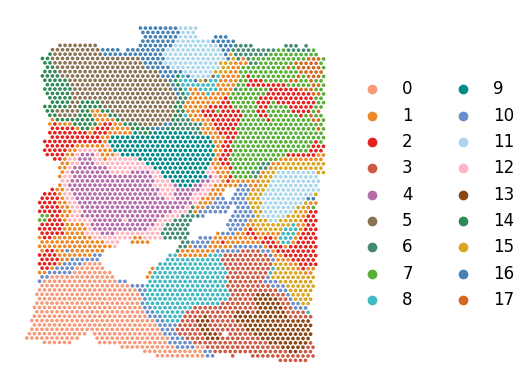

In [408]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                     "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC",
                     "#FFB6C1", "#8B4513", "#2E8B57", "#DAA520", "#4682B4", "#D2691E",
                     "#9ACD32", "#00CED1"]

sc.pl.spatial(adata_com[3987:7785,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

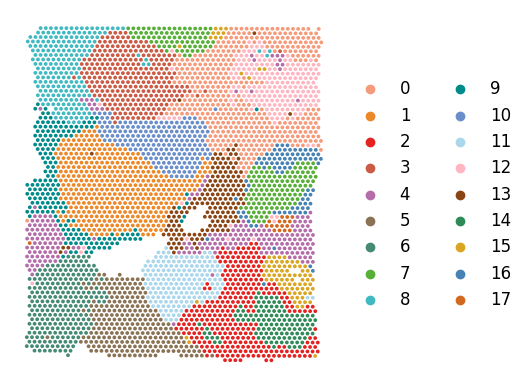

In [409]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                     "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC",
                     "#FFB6C1", "#8B4513", "#2E8B57", "#DAA520", "#4682B4", "#D2691E",
                     "#9ACD32", "#00CED1"]

sc.pl.spatial(adata_com_2[0:3987,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

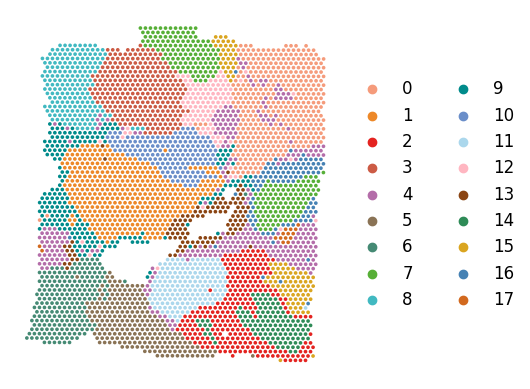

In [410]:
spot_size = 200
pathology_color = ["#F59B7B", "#ED8828", "#E42320", "#CC5B45", "#B46DA9", "#8A7355",
                     "#458A74", "#57AF37", "#41B9C1", "#008B8B", "#6A8EC9", "#ABD7EC",
                     "#FFB6C1", "#8B4513", "#2E8B57", "#DAA520", "#4682B4", "#D2691E",
                     "#9ACD32", "#00CED1"]

sc.pl.spatial(adata_com_2[3987:7785,:], img_key=None, color=['leiden'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [412]:
adata_com

AnnData object with n_obs × n_vars = 7785 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'slice_name', 'leiden'
    uns: 'neighbors', 'umap', 'slice_name_colors', 'Cell_type_colors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'scSLAT_bks', 'X_umap'
    obsp: 'distances', 'connectivities'

In [413]:
adata_1.write('D:\ppppaper\data\After\BRCA_s2_before.h5ad')

In [414]:
adata_2.write('D:\ppppaper\data\After\BRCA_s1_before.h5ad')